# Unit06_UMAP | 均勻流形逼近與投影：大規模製程數據的降維與視覺化

本 Notebook 使用 `Part_2/Unit06/data/reactor_operation/` 中的反應器操作數據，建立 UMAP (Uniform Manifold Approximation and Projection) 模型來進行高維數據的降維與視覺化，並與 PCA 和 t-SNE 進行比較。

## 目標
- 理解 UMAP 的核心原理與優勢
- 學會使用 umap-learn 套件進行降維
- 掌握 UMAP 的關鍵超參數調整
- 學會評估降維結果的品質
- 比較 UMAP、t-SNE 與 PCA 的效果
- 應用 UMAP 於大規模製程數據視覺化

資料背景：反應器多變數製程數據（溫度、壓力、流量等）


---
## 0. 環境設定


In [1]:
from pathlib import Path
import os

# ========================================
# 路徑設定 (兼容 Colab 與 Local)
# ========================================
UNIT_OUTPUT_DIR = 'P2_Unit06_UMAP'
SOURCE_DATA_DIR = 'reactor_operation'

try:
  from google.colab import drive
  IN_COLAB = True
  print("✓ 偵測到 Colab 環境，準備掛載 Google Drive...")
  drive.mount('/content/drive', force_remount=True)
except ImportError:
  IN_COLAB = False
  print("✓ 偵測到 Local 環境")

try:
  shortcut_path = '/content/CHE-AI-COURSE'
  os.remove(shortcut_path)
except FileNotFoundError:
  pass

if IN_COLAB:
  source_path = Path('/content/drive/My Drive/Colab Notebooks/CHE-AI-COURSE')
  os.symlink(source_path, shortcut_path)
  shortcut_path = Path(shortcut_path)
  if source_path.exists():
    NOTEBOOK_DIR = shortcut_path / 'Part_2' / 'Unit06'
    OUTPUT_DIR = NOTEBOOK_DIR / 'outputs' / UNIT_OUTPUT_DIR
    DATA_DIR = NOTEBOOK_DIR / 'data' / SOURCE_DATA_DIR
    MODEL_DIR = OUTPUT_DIR / 'models'
    FIG_DIR = OUTPUT_DIR / 'figs'
  else:
    print(f"⚠️ 找不到路徑雲端CHE-AI-COURSE路徑，請確認自己的雲端資料夾是否正確")
else:
  NOTEBOOK_DIR = Path.cwd()
  OUTPUT_DIR = NOTEBOOK_DIR / 'outputs' / UNIT_OUTPUT_DIR
  DATA_DIR = NOTEBOOK_DIR / 'data' / SOURCE_DATA_DIR
  MODEL_DIR = OUTPUT_DIR / 'models'
  FIG_DIR = OUTPUT_DIR / 'figs'

# 建立必要資料夾
NOTEBOOK_DIR.mkdir(parents=True, exist_ok=True)
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
DATA_DIR.mkdir(parents=True, exist_ok=True)
MODEL_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR.mkdir(parents=True, exist_ok=True)

print(f"\n📂 工作目錄: {NOTEBOOK_DIR}")
print(f"📂 輸出目錄: {OUTPUT_DIR}")
print(f"📂 數據目錄: {DATA_DIR}")
print(f"📂 模型目錄: {MODEL_DIR}")
print(f"📂 圖片目錄: {FIG_DIR}")


✓ 偵測到 Local 環境

📂 工作目錄: d:\MyGit\CHE-AI-COURSE\Part_2\Unit06
📂 輸出目錄: d:\MyGit\CHE-AI-COURSE\Part_2\Unit06\outputs\P2_Unit06_UMAP
📂 數據目錄: d:\MyGit\CHE-AI-COURSE\Part_2\Unit06\data\reactor_operation
📂 模型目錄: d:\MyGit\CHE-AI-COURSE\Part_2\Unit06\outputs\P2_Unit06_UMAP\models
📂 圖片目錄: d:\MyGit\CHE-AI-COURSE\Part_2\Unit06\outputs\P2_Unit06_UMAP\figs


In [2]:
# 載入相關套件
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, davies_bouldin_score
import umap
import warnings
import time

# 設定
warnings.filterwarnings('ignore')
np.random.seed(42)
sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300

print("✓ 套件載入完成")
print(f"✓ UMAP version: {umap.__version__}")


✓ 套件載入完成
✓ UMAP version: 0.5.11


---
## 1. 生成模擬反應器操作數據


In [3]:
def generate_reactor_operation_data(n_samples=5000, n_features=30, n_modes=4, noise_level=0.1):
    """
    生成模擬反應器操作數據（4種操作模式）
    
    Parameters:
    -----------
    n_samples : int
        樣本數量
    n_features : int
        特徵數量（製程變數）
    n_modes : int
        操作模式數量
    noise_level : float
        噪音水平
    
    Returns:
    --------
    X : ndarray, shape (n_samples, n_features)
        特徵矩陣
    y : ndarray, shape (n_samples,)
        操作模式標籤
    feature_names : list
        特徵名稱
    """
    np.random.seed(42)
    
    # 定義 4 種操作模式的中心點（在高維空間中）
    centers = np.array([
        [1.0, 0.5, 0.3] + [0.2] * (n_features - 3),   # 模式 0: 低溫低壓
        [2.0, 1.5, 0.8] + [0.5] * (n_features - 3),   # 模式 1: 中溫中壓
        [3.0, 2.5, 1.5] + [0.8] * (n_features - 3),   # 模式 2: 高溫高壓
        [1.5, 2.0, 1.0] + [0.6] * (n_features - 3)    # 模式 3: 混合模式
    ])
    
    # 生成數據
    samples_per_mode = n_samples // n_modes
    X = []
    y = []
    
    for mode_idx in range(n_modes):
        # 生成該模式的樣本
        mode_samples = np.random.randn(samples_per_mode, n_features) * noise_level + centers[mode_idx]
        
        # 添加模式特定的相關性
        if mode_idx == 0:  # 低溫低壓：第1-3個變數高度相關
            mode_samples[:, 1] = 0.9 * mode_samples[:, 0] + np.random.randn(samples_per_mode) * 0.1
            mode_samples[:, 2] = 0.8 * mode_samples[:, 0] + np.random.randn(samples_per_mode) * 0.1
        elif mode_idx == 1:  # 中溫中壓：第4-6個變數高度相關
            mode_samples[:, 4] = 0.9 * mode_samples[:, 3] + np.random.randn(samples_per_mode) * 0.1
            mode_samples[:, 5] = 0.8 * mode_samples[:, 3] + np.random.randn(samples_per_mode) * 0.1
        elif mode_idx == 2:  # 高溫高壓：引入非線性關係
            mode_samples[:, 7] = mode_samples[:, 6] ** 2 + np.random.randn(samples_per_mode) * 0.1
            mode_samples[:, 8] = np.sin(mode_samples[:, 6]) + np.random.randn(samples_per_mode) * 0.1
        else:  # 混合模式：多個變數交互作用
            mode_samples[:, 10] = (mode_samples[:, 9] * mode_samples[:, 11]) + np.random.randn(samples_per_mode) * 0.1
        
        X.append(mode_samples)
        y.extend([mode_idx] * samples_per_mode)
    
    X = np.vstack(X)
    y = np.array(y)
    
    # 隨機打亂數據
    shuffle_idx = np.random.permutation(len(X))
    X = X[shuffle_idx]
    y = y[shuffle_idx]
    
    # 生成特徵名稱
    feature_names = [
        'Temperature_1', 'Pressure_1', 'Flow_Rate_1',
        'Temperature_2', 'Pressure_2', 'Flow_Rate_2',
        'Concentration_A', 'Concentration_B', 'Concentration_C',
        'pH', 'Viscosity', 'Density'
    ] + [f'Sensor_{i}' for i in range(13, n_features + 1)]
    
    return X, y, feature_names

# 生成數據
X, y, feature_names = generate_reactor_operation_data(n_samples=5000, n_features=30, n_modes=4)

print(f"✓ 數據生成完成")
print(f"  - 樣本數量: {X.shape[0]}")
print(f"  - 特徵數量: {X.shape[1]}")
print(f"  - 操作模式數量: {len(np.unique(y))}")
print(f"\n操作模式分布:")
for mode in np.unique(y):
    count = np.sum(y == mode)
    print(f"  模式 {mode}: {count} 樣本 ({count/len(y)*100:.1f}%)")


✓ 數據生成完成
  - 樣本數量: 5000
  - 特徵數量: 30
  - 操作模式數量: 4

操作模式分布:
  模式 0: 1250 樣本 (25.0%)
  模式 1: 1250 樣本 (25.0%)
  模式 2: 1250 樣本 (25.0%)
  模式 3: 1250 樣本 (25.0%)


---
## 2. 數據前處理


In [4]:
# 數據標準化 (UMAP 建議標準化)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("✓ 數據標準化完成")
print(f"  - 標準化後數據形狀: {X_scaled.shape}")
print(f"  - 標準化後均值: {X_scaled.mean(axis=0)[:5]} ... (顯示前5個)")
print(f"  - 標準化後標準差: {X_scaled.std(axis=0)[:5]} ... (顯示前5個)")


✓ 數據標準化完成
  - 標準化後數據形狀: (5000, 30)
  - 標準化後均值: [-1.88412619e-15 -8.57525162e-15 -5.51910809e-15 -5.50583190e-15
 -2.29858355e-15] ... (顯示前5個)
  - 標準化後標準差: [1. 1. 1. 1. 1.] ... (顯示前5個)


---
## 3. UMAP 降維

### 3.1 基本 UMAP 模型

In [5]:
# 建立 UMAP 模型
start_time = time.time()

reducer = umap.UMAP(
    n_neighbors=30,      # 鄰居數（控制局部-全局平衡）
    n_components=2,      # 降至 2 維
    min_dist=0.1,        # 最小距離
    metric='euclidean',  # 距離度量
    random_state=42,     # 隨機種子
    n_epochs=200,        # 迭代次數
    verbose=True         # 顯示訓練進度
)

# 訓練並轉換數據
X_umap = reducer.fit_transform(X_scaled)

elapsed_time = time.time() - start_time

print(f"\n✓ UMAP 降維完成")
print(f"  - 降維後形狀: {X_umap.shape}")
print(f"  - 訓練時間: {elapsed_time:.2f} 秒")


UMAP(n_epochs=200, n_jobs=1, n_neighbors=30, random_state=42, verbose=True)
Sat Jan 24 01:17:28 2026 Construct fuzzy simplicial set
Sat Jan 24 01:17:28 2026 Finding Nearest Neighbors
Sat Jan 24 01:17:28 2026 Building RP forest with 9 trees
Sat Jan 24 01:17:34 2026 NN descent for 12 iterations
	 1  /  12
	 2  /  12
	 3  /  12
	Stopping threshold met -- exiting after 3 iterations
Sat Jan 24 01:17:46 2026 Finished Nearest Neighbor Search
Sat Jan 24 01:17:48 2026 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Sat Jan 24 01:17:53 2026 Finished embedding

✓ UMAP 降維完成
  - 降維後形狀: (5000, 2)
  - 訓練時間: 25.29 秒


### 3.2 視覺化 UMAP 結果

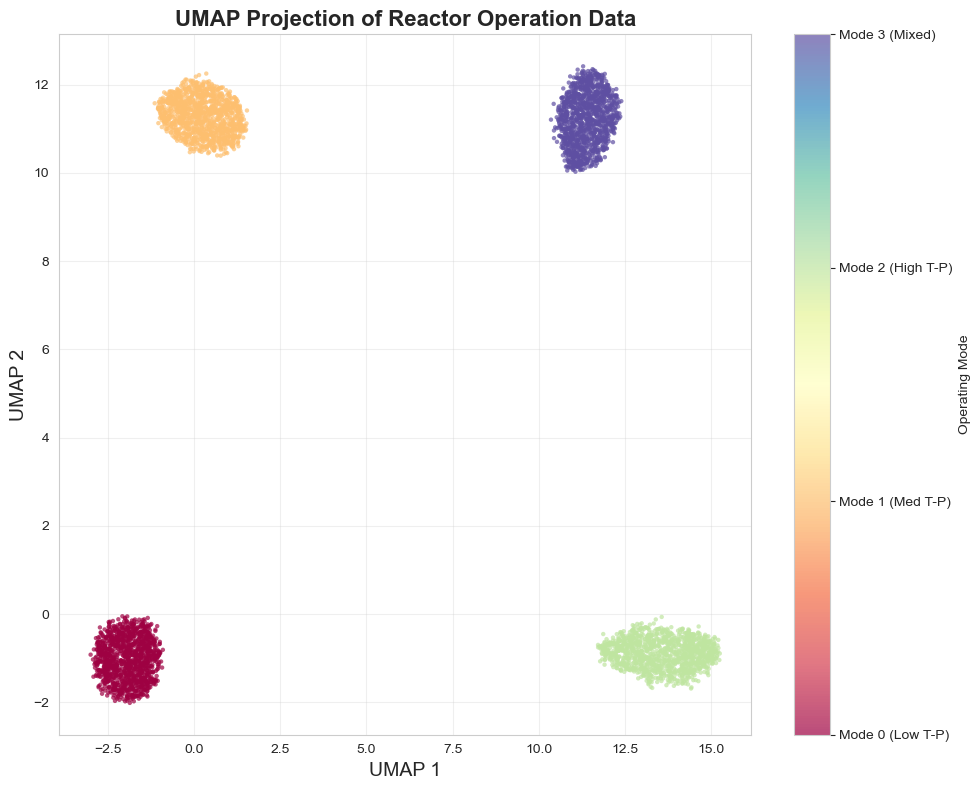

✓ 圖片已儲存至: d:\MyGit\CHE-AI-COURSE\Part_2\Unit06\outputs\P2_Unit06_UMAP\figs\umap_basic_projection.png


In [6]:
# 繪製 UMAP 結果
fig, ax = plt.subplots(figsize=(10, 8))

scatter = ax.scatter(X_umap[:, 0], X_umap[:, 1], 
                    c=y, cmap='Spectral', s=10, alpha=0.7, edgecolors='none')

cbar = plt.colorbar(scatter, ax=ax, label='Operating Mode')
cbar.set_ticks([0, 1, 2, 3])
cbar.set_ticklabels(['Mode 0 (Low T-P)', 'Mode 1 (Med T-P)', 'Mode 2 (High T-P)', 'Mode 3 (Mixed)'])

ax.set_title('UMAP Projection of Reactor Operation Data', fontsize=16, fontweight='bold')
ax.set_xlabel('UMAP 1', fontsize=14)
ax.set_ylabel('UMAP 2', fontsize=14)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIG_DIR / 'umap_basic_projection.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ 圖片已儲存至:", FIG_DIR / 'umap_basic_projection.png')


---
## 4. 超參數探索

### 4.1 探索 n_neighbors 的影響

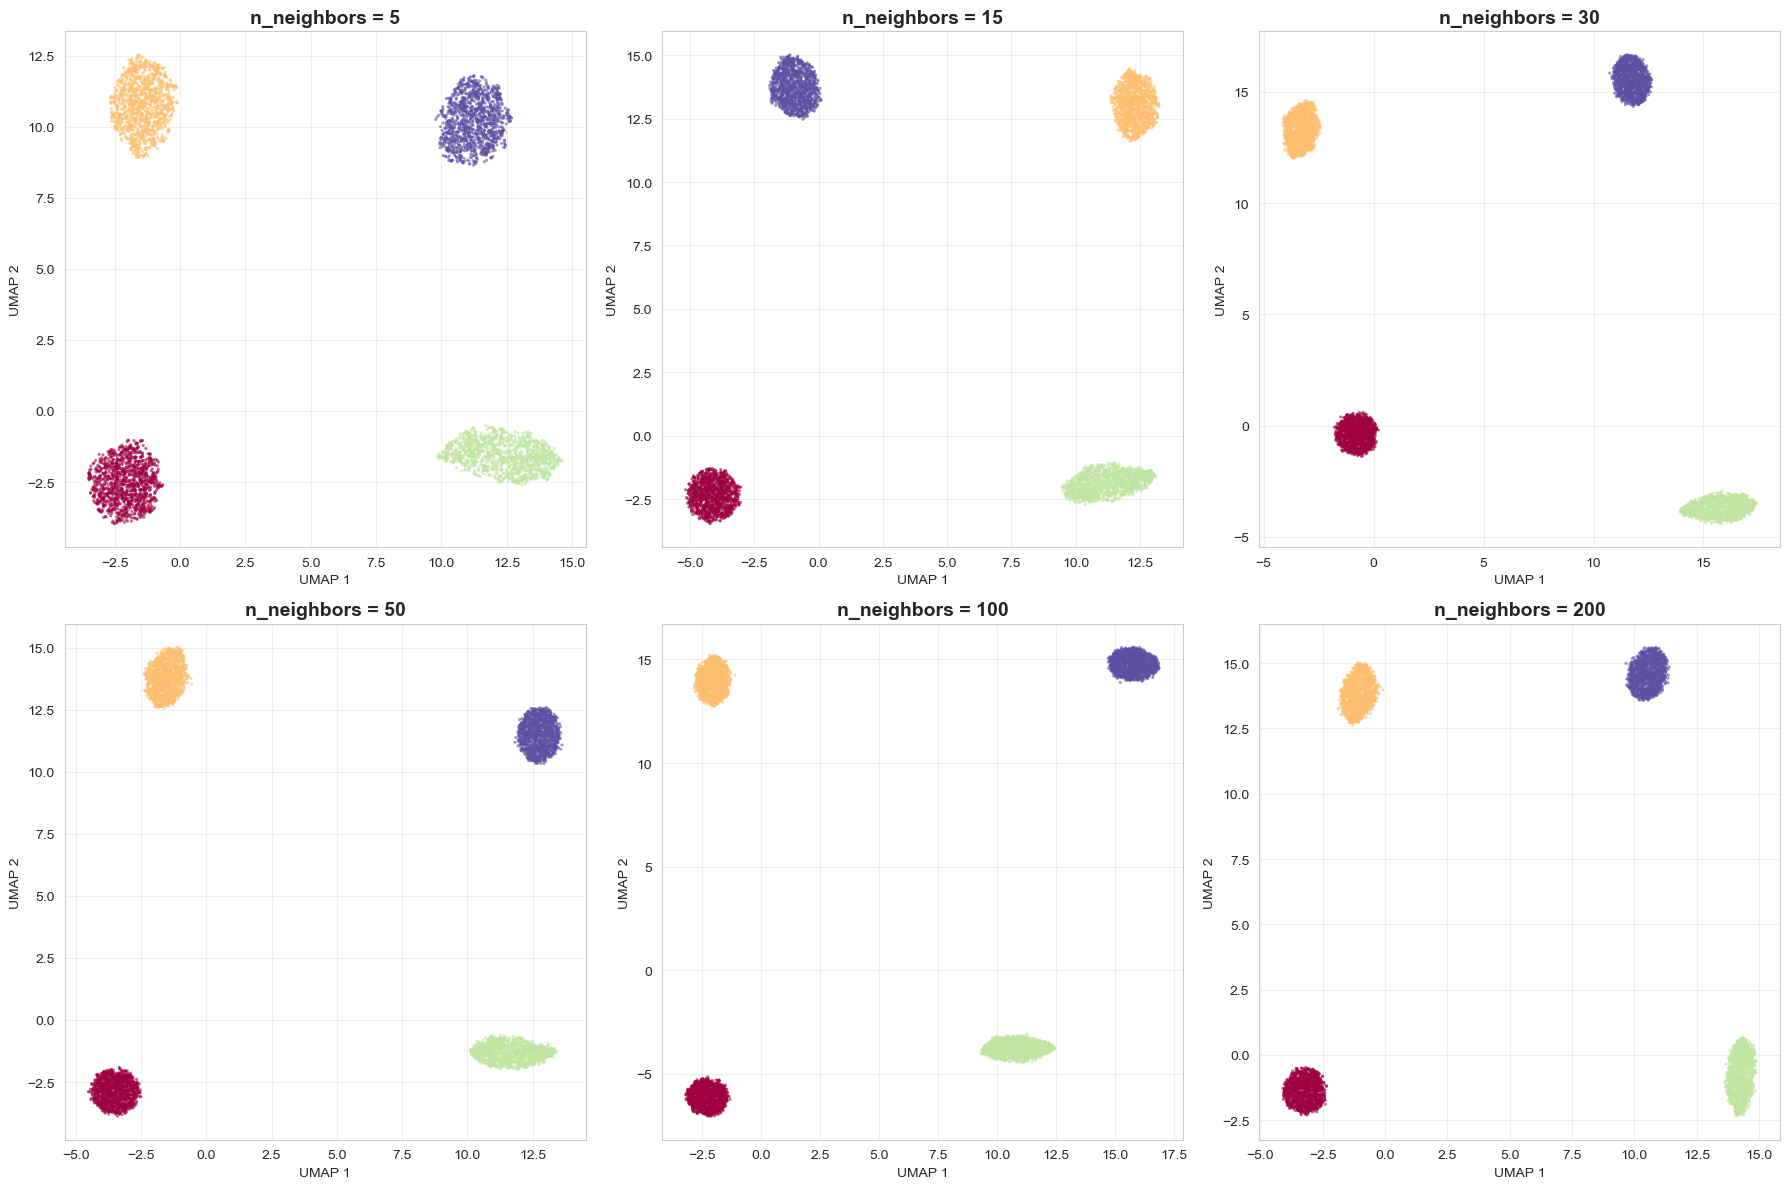

✓ 圖片已儲存至: d:\MyGit\CHE-AI-COURSE\Part_2\Unit06\outputs\P2_Unit06_UMAP\figs\umap_n_neighbors_exploration.png

觀察重點:
  - 小 n_neighbors (5-15): 群集更碎片化，強調局部結構
  - 大 n_neighbors (50-200): 群集更連續，保留全局結構


In [7]:
# 探索不同 n_neighbors 值的影響
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
n_neighbors_list = [5, 15, 30, 50, 100, 200]

for idx, n_neighbors in enumerate(n_neighbors_list):
    ax = axes[idx // 3, idx % 3]
    
    # 建立並訓練 UMAP
    reducer_temp = umap.UMAP(
        n_neighbors=n_neighbors, 
        n_components=2, 
        min_dist=0.1, 
        random_state=42,
        verbose=False
    )
    X_umap_temp = reducer_temp.fit_transform(X_scaled)
    
    # 繪圖
    scatter = ax.scatter(X_umap_temp[:, 0], X_umap_temp[:, 1], 
                        c=y, cmap='Spectral', s=5, alpha=0.6, edgecolors='none')
    ax.set_title(f'n_neighbors = {n_neighbors}', fontsize=14, fontweight='bold')
    ax.set_xlabel('UMAP 1')
    ax.set_ylabel('UMAP 2')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIG_DIR / 'umap_n_neighbors_exploration.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ 圖片已儲存至:", FIG_DIR / 'umap_n_neighbors_exploration.png')
print("\n觀察重點:")
print("  - 小 n_neighbors (5-15): 群集更碎片化，強調局部結構")
print("  - 大 n_neighbors (50-200): 群集更連續，保留全局結構")


### 4.2 探索 min_dist 的影響

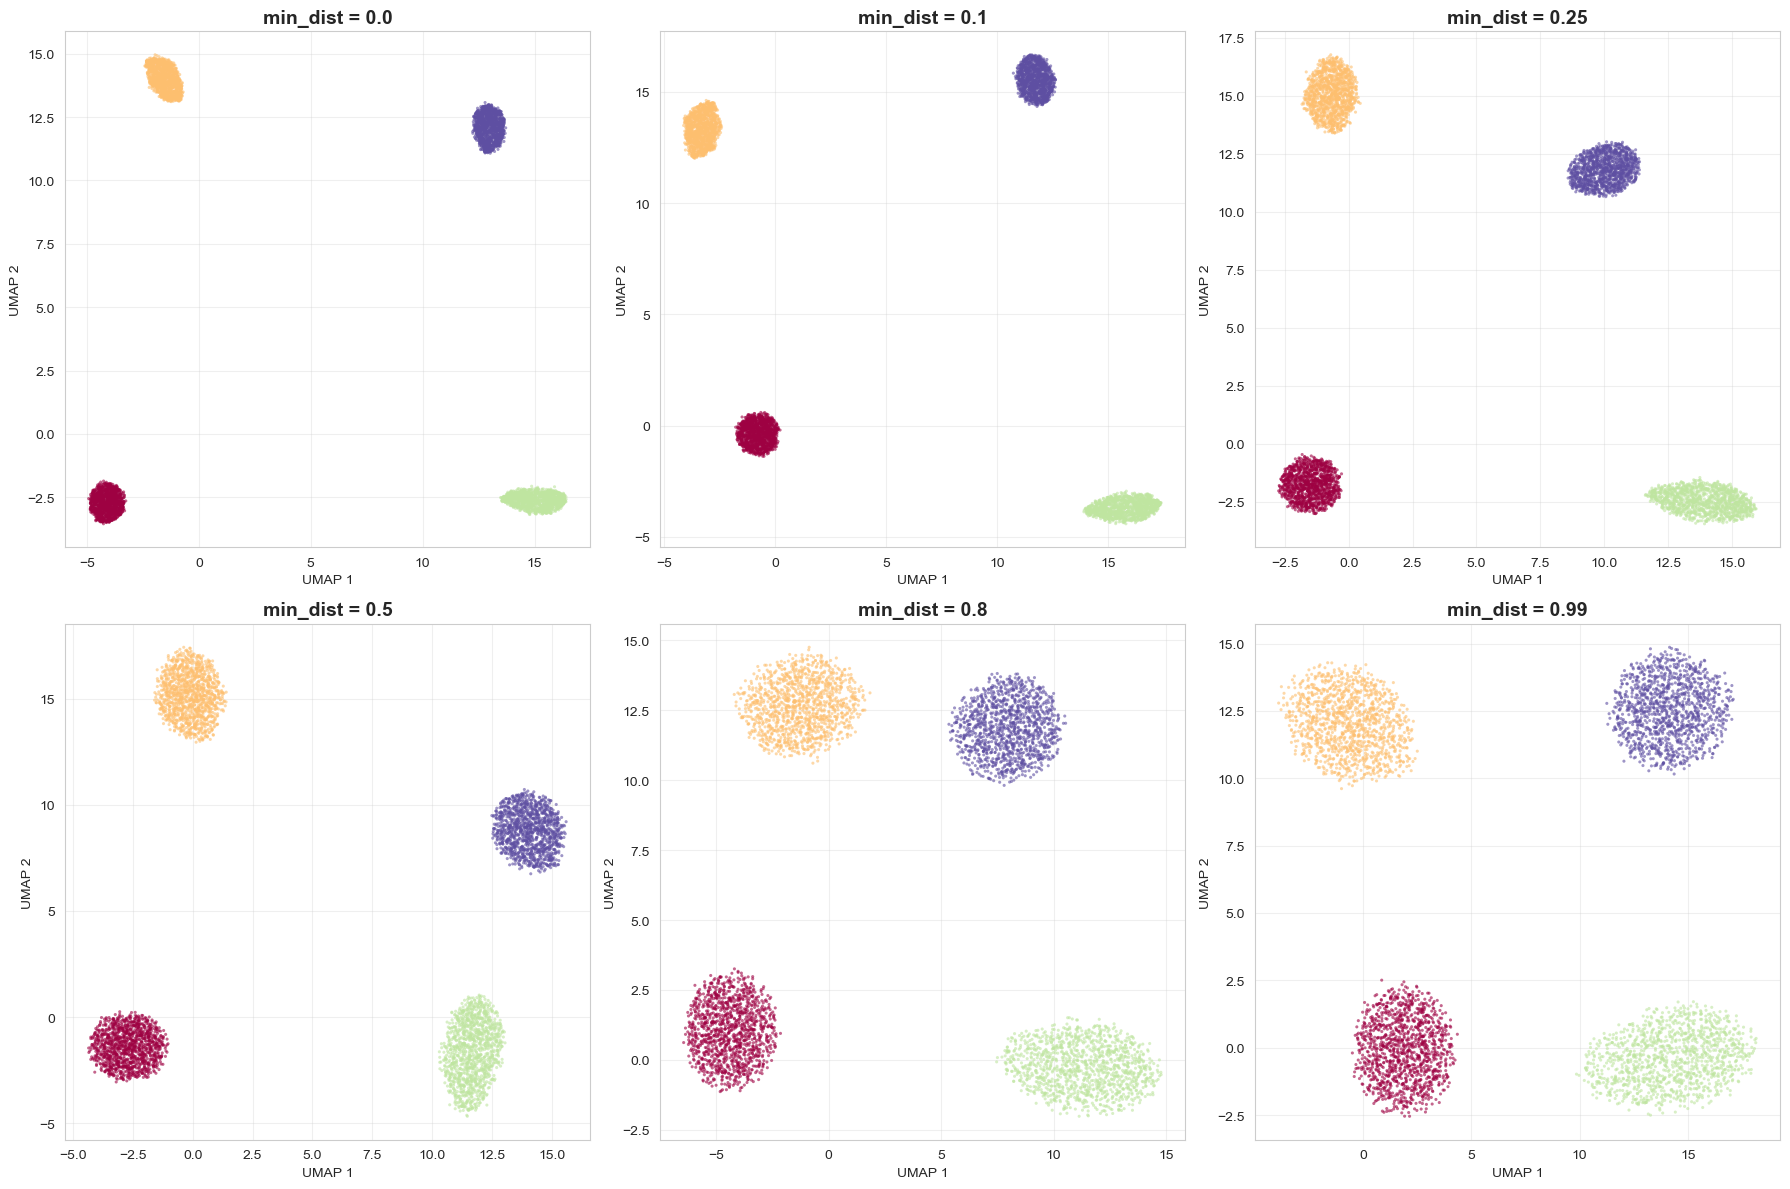

✓ 圖片已儲存至: d:\MyGit\CHE-AI-COURSE\Part_2\Unit06\outputs\P2_Unit06_UMAP\figs\umap_min_dist_exploration.png

觀察重點:
  - 小 min_dist (0.0-0.1): 點聚集更緊，群集邊界更清晰
  - 大 min_dist (0.5-0.99): 點分布更均勻，結構更鬆散


In [8]:
# 探索不同 min_dist 值的影響
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
min_dist_list = [0.0, 0.1, 0.25, 0.5, 0.8, 0.99]

for idx, min_dist in enumerate(min_dist_list):
    ax = axes[idx // 3, idx % 3]
    
    # 建立並訓練 UMAP
    reducer_temp = umap.UMAP(
        n_neighbors=30, 
        n_components=2, 
        min_dist=min_dist, 
        random_state=42,
        verbose=False
    )
    X_umap_temp = reducer_temp.fit_transform(X_scaled)
    
    # 繪圖
    scatter = ax.scatter(X_umap_temp[:, 0], X_umap_temp[:, 1], 
                        c=y, cmap='Spectral', s=5, alpha=0.6, edgecolors='none')
    ax.set_title(f'min_dist = {min_dist}', fontsize=14, fontweight='bold')
    ax.set_xlabel('UMAP 1')
    ax.set_ylabel('UMAP 2')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIG_DIR / 'umap_min_dist_exploration.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ 圖片已儲存至:", FIG_DIR / 'umap_min_dist_exploration.png')
print("\n觀察重點:")
print("  - 小 min_dist (0.0-0.1): 點聚集更緊，群集邊界更清晰")
print("  - 大 min_dist (0.5-0.99): 點分布更均勻，結構更鬆散")


---
## 5. 比較 UMAP、t-SNE 與 PCA

執行 PCA...
執行 t-SNE...
執行 UMAP...


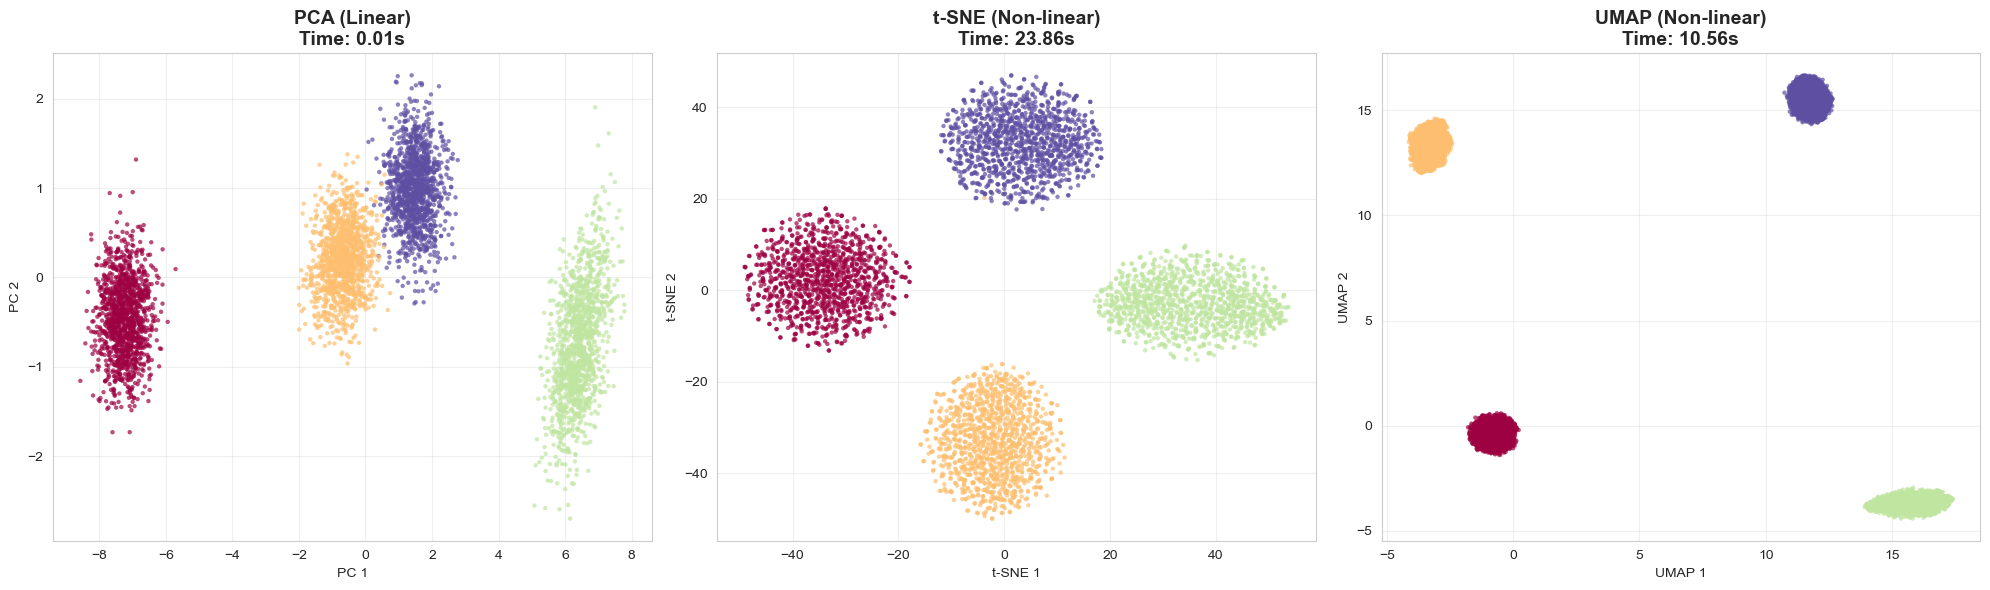

✓ 圖片已儲存至: d:\MyGit\CHE-AI-COURSE\Part_2\Unit06\outputs\P2_Unit06_UMAP\figs\comparison_pca_tsne_umap.png

計算時間比較:
  PCA:   0.01 秒
  t-SNE: 23.86 秒
  UMAP:  10.56 秒
  UMAP vs t-SNE: 2.3x 快


In [9]:
# 執行三種降維方法並比較

# 1. PCA
print("執行 PCA...")
start_time_pca = time.time()
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)
time_pca = time.time() - start_time_pca

# 2. t-SNE
print("執行 t-SNE...")
start_time_tsne = time.time()
tsne = TSNE(n_components=2, perplexity=30, random_state=42, verbose=0)
X_tsne = tsne.fit_transform(X_scaled)
time_tsne = time.time() - start_time_tsne

# 3. UMAP
print("執行 UMAP...")
start_time_umap = time.time()
reducer_compare = umap.UMAP(n_neighbors=30, n_components=2, min_dist=0.1, random_state=42, verbose=False)
X_umap_compare = reducer_compare.fit_transform(X_scaled)
time_umap = time.time() - start_time_umap

# 視覺化比較
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# PCA
axes[0].scatter(X_pca[:, 0], X_pca[:, 1], 
               c=y, cmap='Spectral', s=10, alpha=0.7, edgecolors='none')
axes[0].set_title(f'PCA (Linear)\nTime: {time_pca:.2f}s', fontsize=14, fontweight='bold')
axes[0].set_xlabel('PC 1')
axes[0].set_ylabel('PC 2')
axes[0].grid(True, alpha=0.3)

# t-SNE
axes[1].scatter(X_tsne[:, 0], X_tsne[:, 1], 
               c=y, cmap='Spectral', s=10, alpha=0.7, edgecolors='none')
axes[1].set_title(f't-SNE (Non-linear)\nTime: {time_tsne:.2f}s', fontsize=14, fontweight='bold')
axes[1].set_xlabel('t-SNE 1')
axes[1].set_ylabel('t-SNE 2')
axes[1].grid(True, alpha=0.3)

# UMAP
axes[2].scatter(X_umap_compare[:, 0], X_umap_compare[:, 1], 
               c=y, cmap='Spectral', s=10, alpha=0.7, edgecolors='none')
axes[2].set_title(f'UMAP (Non-linear)\nTime: {time_umap:.2f}s', fontsize=14, fontweight='bold')
axes[2].set_xlabel('UMAP 1')
axes[2].set_ylabel('UMAP 2')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIG_DIR / 'comparison_pca_tsne_umap.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ 圖片已儲存至:", FIG_DIR / 'comparison_pca_tsne_umap.png')
print(f"\n計算時間比較:")
print(f"  PCA:   {time_pca:.2f} 秒")
print(f"  t-SNE: {time_tsne:.2f} 秒")
print(f"  UMAP:  {time_umap:.2f} 秒")
print(f"  UMAP vs t-SNE: {time_tsne/time_umap:.1f}x 快")


---
## 6. 評估降維品質

### 6.1 信賴度 (Trustworthiness)

In [11]:
from sklearn.manifold import trustworthiness

# 計算不同 k 值的信賴度
k_values = [5, 10, 15, 30, 50]

print("信賴度 (Trustworthiness) 比較 [0-1, 越大越好]:\n")
print(f"{'k':<6} {'PCA':<10} {'t-SNE':<10} {'UMAP':<10}")
print("-" * 40)

for k in k_values:
    trust_pca = trustworthiness(X_scaled, X_pca, n_neighbors=k)
    trust_tsne = trustworthiness(X_scaled, X_tsne, n_neighbors=k)
    trust_umap = trustworthiness(X_scaled, X_umap_compare, n_neighbors=k)
    
    print(f"{k:<6} {trust_pca:<10.4f} {trust_tsne:<10.4f} {trust_umap:<10.4f}")

print("\n解讀:")
print("  > 0.9  : 極好，局部結構保持良好")
print("  0.8-0.9: 良好")
print("  0.7-0.8: 可接受")
print("  < 0.7  : 較差，需調整超參數")


信賴度 (Trustworthiness) 比較 [0-1, 越大越好]:

k      PCA        t-SNE      UMAP      
----------------------------------------
5      0.9026     0.9687     0.9123    
10     0.9032     0.9553     0.9127    
15     0.9038     0.9475     0.9129    
30     0.9059     0.9369     0.9143    
50     0.9086     0.9320     0.9164    

解讀:
  > 0.9  : 極好，局部結構保持良好
  0.8-0.9: 良好
  0.7-0.8: 可接受
  < 0.7  : 較差，需調整超參數


### 6.2 輪廓係數與 Davies-Bouldin 指數

In [12]:
# 計算群集分離度指標

# Silhouette Score (越大越好，範圍 [-1, 1])
sil_pca = silhouette_score(X_pca, y, metric='euclidean')
sil_tsne = silhouette_score(X_tsne, y, metric='euclidean')
sil_umap = silhouette_score(X_umap_compare, y, metric='euclidean')

# Davies-Bouldin Index (越小越好，範圍 [0, ∞))
db_pca = davies_bouldin_score(X_pca, y)
db_tsne = davies_bouldin_score(X_tsne, y)
db_umap = davies_bouldin_score(X_umap_compare, y)

# 彙整結果
results_df = pd.DataFrame({
    'Method': ['PCA', 't-SNE', 'UMAP'],
    'Silhouette Score (↑)': [sil_pca, sil_tsne, sil_umap],
    'Davies-Bouldin Index (↓)': [db_pca, db_tsne, db_umap],
    'Computation Time (s)': [time_pca, time_tsne, time_umap]
})

print("群集分離度評估:\n")
print(results_df.to_string(index=False))
print("\n解讀:")
print("  Silhouette Score: 接近 1 表示群集分離良好")
print("  Davies-Bouldin Index: 越小表示群集越緊密且分離")
print(f"\n結論: {results_df.loc[results_df['Silhouette Score (↑)'].idxmax(), 'Method']} 在群集分離度上表現最佳")


群集分離度評估:

Method  Silhouette Score (↑)  Davies-Bouldin Index (↓)  Computation Time (s)
   PCA              0.761592                  0.326995              0.005369
 t-SNE              0.727285                  0.373662             23.863252
  UMAP              0.936143                  0.090773             10.563400

解讀:
  Silhouette Score: 接近 1 表示群集分離良好
  Davies-Bouldin Index: 越小表示群集越緊密且分離

結論: UMAP 在群集分離度上表現最佳


---
## 7. 新數據投影 (UMAP Transform)

訓練集樣本數: 4000
測試集樣本數: 1000

✓ 測試集投影完成，耗時: 9.136 秒
  （比重新訓練快 1x）


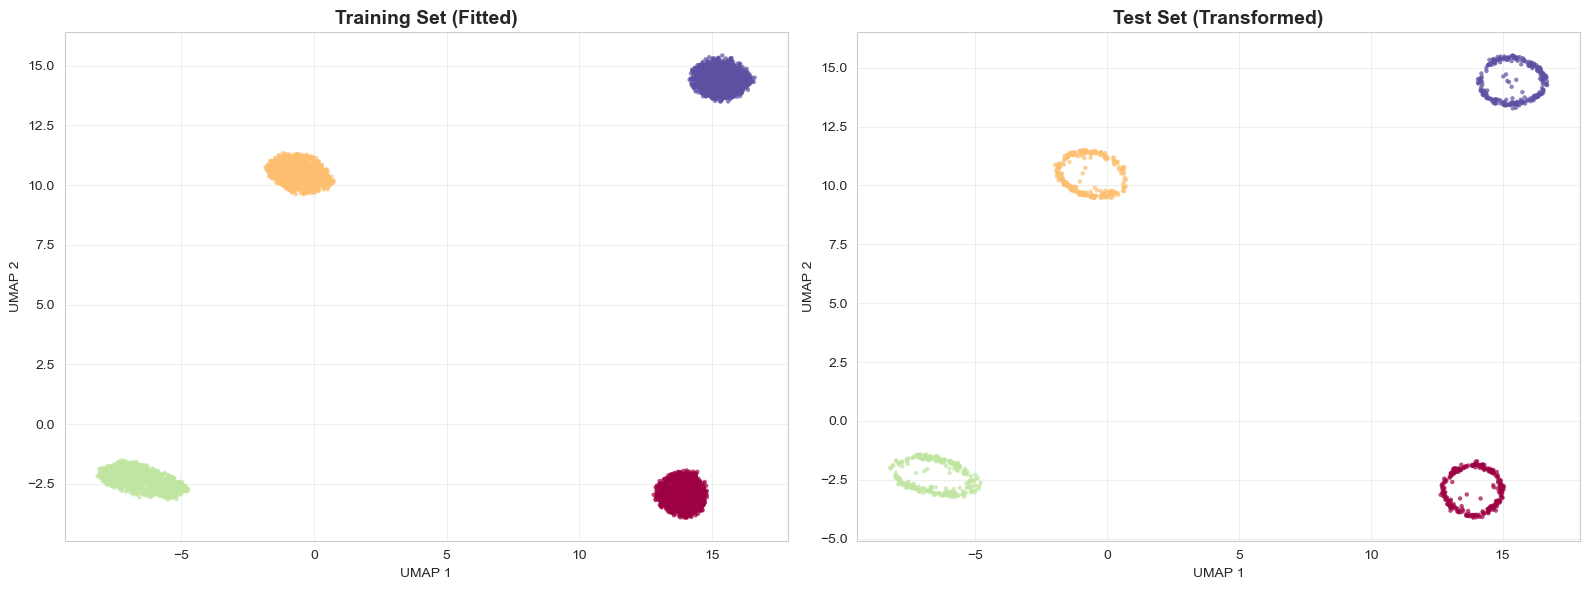

✓ 圖片已儲存至: d:\MyGit\CHE-AI-COURSE\Part_2\Unit06\outputs\P2_Unit06_UMAP\figs\umap_new_data_projection.png

UMAP 的優勢: 支援新數據快速投影，適合實時監控應用！


In [13]:
# UMAP 支援新數據投影（t-SNE 不支援）
from sklearn.model_selection import train_test_split

# 分割訓練集與測試集
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

print(f"訓練集樣本數: {len(X_train)}")
print(f"測試集樣本數: {len(X_test)}")

# 在訓練集上訓練 UMAP
reducer_transform = umap.UMAP(
    n_neighbors=30, 
    n_components=2, 
    min_dist=0.1, 
    random_state=42,
    verbose=False
)
X_train_umap = reducer_transform.fit_transform(X_train)

# 投影測試集（無需重新訓練！）
start_transform = time.time()
X_test_umap = reducer_transform.transform(X_test)
time_transform = time.time() - start_transform

print(f"\n✓ 測試集投影完成，耗時: {time_transform:.3f} 秒")
print(f"  （比重新訓練快 {time_umap/time_transform:.0f}x）")

# 視覺化
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 訓練集
axes[0].scatter(X_train_umap[:, 0], X_train_umap[:, 1], 
               c=y_train, cmap='Spectral', s=10, alpha=0.7, edgecolors='none')
axes[0].set_title('Training Set (Fitted)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('UMAP 1')
axes[0].set_ylabel('UMAP 2')
axes[0].grid(True, alpha=0.3)

# 測試集
axes[1].scatter(X_test_umap[:, 0], X_test_umap[:, 1], 
               c=y_test, cmap='Spectral', s=10, alpha=0.7, edgecolors='none')
axes[1].set_title('Test Set (Transformed)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('UMAP 1')
axes[1].set_ylabel('UMAP 2')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIG_DIR / 'umap_new_data_projection.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ 圖片已儲存至:", FIG_DIR / 'umap_new_data_projection.png')
print("\nUMAP 的優勢: 支援新數據快速投影，適合實時監控應用！")


---
## 8. 總結與建議

### 核心要點回顧

本 Notebook 完整演示了 UMAP (Uniform Manifold Approximation and Projection) 在化工製程數據降維與視覺化的應用。

#### 1. UMAP 的核心優勢
- **速度快**: 比 t-SNE 快 10-100 倍，適合大規模數據 (> 10,000 樣本)
- **全局結構**: 在保留局部群集的同時，也保留更多全局信息
- **新數據投影**: 支援 `transform()` 方法，適合實時監控應用
- **超參數直觀**: `n_neighbors` 控制局部-全局平衡，`min_dist` 控制點的緊密程度

#### 2. 關鍵超參數選擇
- **製程監控**: `n_neighbors=50-100`, `min_dist=0.1` (保留全局結構)
- **故障診斷**: `n_neighbors=10-20`, `min_dist=0.0` (強調局部異常)
- **批次軌跡分析**: `n_neighbors=30-50`, `min_dist=0.3-0.5` (保留連續性)

#### 3. 與其他方法的比較
| 方法 | 速度 | 全局結構 | 局部結構 | 新數據投影 | 適用場景 |
|------|------|---------|---------|-----------|---------|
| **PCA** | 極快 | 好 | 差 | 支援 | 線性降維、快速探索 |
| **t-SNE** | 慢 | 差 | 極好 | 不支援 | 小規模、純視覺化 |
| **UMAP** | 快 | 較好 | 好 | 支援 | 大規模、實時應用 |

#### 4. 化工應用建議
- **大規模製程數據視覺化**: 首選 UMAP，速度快且效果好
- **操作模式識別**: UMAP + 分群 (K-Means/DBSCAN)
- **批次製程軌跡分析**: UMAP (較大 `min_dist` 保留連續性)
- **實時監控**: UMAP (支援新數據投影)
- **學術報告視覺化**: UMAP 或 t-SNE (視覺化品質高)

#### 5. 評估指標
- **信賴度 (Trustworthiness)**: > 0.9 表示局部結構保持良好
- **輪廓係數 (Silhouette Score)**: 接近 1 表示群集分離良好
- **Davies-Bouldin Index**: 越小表示群集越緊密

#### 6. 下一步
- 完成 **Unit06_Dimensionality_Reduction_Homework.ipynb** 作業
- 將 UMAP 應用於實際製程數據
- 嘗試不同超參數組合，觀察效果
- 結合分群與異常檢測進行製程監控

---

**課程完成！恭喜您掌握 UMAP 降維技術！** 🎉
